from https://www.kaggle.com/code/hugosjoberg/house-prices-prediction-using-keras

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
show_graphs = False

In [3]:
# Read in train data
try:
    df_train = pd.read_csv('df_listings_v06.csv', index_col=0)
except:
    !wget https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
    df_train = pd.read_csv('df_listings_v06.csv', index_col=0)

--2022-11-17 15:06:43--  https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5116878 (4.9M) [text/plain]
Saving to: ‘df_listings_v06.csv.11’

df_listings_v06.csv 100%[===================>]   4.88M  6.14MB/s    in 0.8s    

2022-11-17 15:06:44 (6.14 MB/s) - ‘df_listings_v06.csv.11’ saved [5116878/5116878]



In [4]:
df_train.head()

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN


# Prepare data
    Investigate what data that has a linear or some kind of relation to the sale price
    Drop the unimportant features or less unimportant features
    Drop features which has many NaN values

In [5]:
#descriptive statistics summary
df_train['Price'].describe()

count     46871.000000
mean     425069.390775
std      107227.324906
min      100000.000000
25%      349950.000000
50%      425000.000000
75%      515000.000000
max      600000.000000
Name: Price, dtype: float64

In [6]:
#histogram
if show_graphs:
    sns.distplot(df_train[''                          'Price']);

In [7]:
#skewness and kurtosis
print("Skewness: %f" % df_train['Price'].skew())
print("Kurtosis: %f" % df_train['Price'].kurt())

Skewness: -0.123988
Kurtosis: -0.933832


    - Skewness means the top of the iceberg is not in the middle but rather towards left or right.
    - Kurtosis describe if the gaussian distrubution is very small and narrow or very wide

Use a heatmap to see which features have strongest correlation with house price

In [8]:
if show_graphs:
    #correlation matrix
    corrmat = df_train.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True);

Here we can detect multicollinearity for example basement area and the area of the first floor so these hold more or less the same kind of data. The same goes for garage variables, for example if you have a big garage you also have more cars in it.

Some variables are also important for the SalePrice with the biggest one being OverallQual

Let's plot top 10 most important for correlating with SalePrice

In [9]:
if show_graphs:
    #saleprice correlation matrix
    k = 10 #number of variables for heatmap
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df_train[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

From this plot we can draw the conclusion that:
    - OverallQual is important
    - GrLivArea is also important
    - TotalBsmtSF is important
    - GarageCars and GarageArea are two important features but we drop GarageArea since it is more or less the same information as GarageCars
    - TotalBsmtSF and 1stFlrSF are also more or less the same so we drop 1StFlrSF
    - TotRmsAbvGrd and GrLivArea are also strongly correlated to let's drop TotRmsAbvGrd
 
 Let's scatterplot these important features.

In [10]:
if show_graphs:
    #scatterplot
    sns.set()
    cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
    sns.pairplot(df_train[cols], size = 2.5)
    plt.show();

The basement area and total living area seems to have similarities their saleprice plot looks almost identical, let's drop basement area.

Maybe also remove year built data since this data can be tricky to use.

Let's have a  look at the missing data.

Let's display a % of the data that is missing from some columns.

In [11]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
tenure.tenureType,2744,0.058544
Price,0,0.000000
bedrooms,0,0.000000
bathrooms,0,0.000000
nearestStation,0,0.000000
location.latitude,0,0.000000
location.longitude,0,0.000000
latitude_deviation,0,0.000000
longitude_deviation,0,0.000000


Some of theese features are of interest for us and they don't show a massive shortage of data so lets create mean data for those values.

In [12]:
df_train = df_train.fillna(df_train.mean())

/tmp/ipykernel_90/2439521282.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train = df_train.fillna(df_train.mean())


Now let's remove outliers for example data that doesn't match what we expect like an insane price for a house

To do this we standardize the data so that the mean is 0 and a standard deviation of 1. 

In [13]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['Price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-3.03162332]
 [-3.03162332]
 [-2.98499292]
 [-2.95701467]
 [-2.93836251]
 [-2.92903643]
 [-2.90105819]
 [-2.89756091]
 [-2.89173211]
 [-2.89173211]]

outer range (high) of the distribution:
[[1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]
 [1.63141695]]


/tmp/ipykernel_90/2419163164.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  saleprice_scaled = StandardScaler().fit_transform(df_train['Price'][:,np.newaxis]);


    -Values that are similar to each other stay close to 0
    -Values that are a bit odd get high values such as the 7 values.

In [14]:
if show_graphs:
    #bivariate analysis saleprice/grlivarea
    var = 'bedrooms'
    data = pd.concat([df_train['Price'], df_train[var]], axis=1)
    data.plot.scatter(x=var, y='Price', ylim=(0,800000));

What has been revealed:

* The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural area and that could explain the low price. I'm not sure about this but I'm quite confident that these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.
* The two observations in the top of the plot are those 7 something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

# Prepare data
Right now I think we have an idea of what kind of data we are interested in and what data we don't think are useful for us. Let's build a pipeline for removing the data.

Let's reload the data so we can have a fresh start!

In [15]:
#df_train = pd.read_csv('house_prices_train.csv', index_col=0)
df_train = pd.read_csv('df_listings_v06.csv', index_col=0)

Let's not log the data since a neural network is quite good at working with non-linear data. I also tested and verified that the model didn't perform better or worse if I logged the data before hand.

In [16]:
cols = ['Price','bedrooms','bathrooms','nearestStation','location.latitude','location.longitude','latitude_deviation','longitude_deviation']
features = ['bedrooms','bathrooms','nearestStation','location.latitude','location.longitude','latitude_deviation','longitude_deviation']
df_train = df_train[cols]
# Create dummy values
df_train = pd.get_dummies(df_train)
#filling NA's with the mean of the column:
df_train = df_train.fillna(df_train.mean())
# Always standard scale the data before using NN
scale = StandardScaler()
X_train = df_train[features]
X_train = scale.fit_transform(X_train)
# Y is just the 'SalePrice' column
y = df_train['Price'].values
seed = 7
np.random.seed(seed)
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=seed)
X_test.shape, y_test.shape

((15468, 7), (15468,))

In [17]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [18]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dense_2 (Dense)             (None, 40)                1240      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=32)

Epoch 1/150
982/982 [==============================] - 4s 2ms/step - loss: 167150141440.0000 - mean_absolute_error: 392699.1250 - val_loss: 85979242496.0000 - val_mean_absolute_error: 274270.8750
Epoch 2/150
982/982 [==============================] - 2s 3ms/step - loss: 26992179200.0000 - mean_absolute_error: 130322.3438 - val_loss: 11178597376.0000 - val_mean_absolute_error: 83946.8203
Epoch 3/150
982/982 [==============================] - 2s 2ms/step - loss: 10464874496.0000 - mean_absolute_error: 81421.1250 - val_loss: 9636891648.0000 - val_mean_absolute_error: 78622.2031
Epoch 4/150
982/982 [==============================] - 2s 2ms/step - loss: 9235275776.0000 - mean_absolute_error: 76928.1797 - val_loss: 8668361728.0000 - val_mean_absolute_error: 74808.7969
Epoch 5/150
982/982 [==============================] - 2s 2ms/step - loss: 8417892864.0000 - mean_absolute_error: 73771.8672 - val_loss: 8017822720.0000 - val_mean_absolute_error: 72240.0469
Epoch 6/150
982/982 [===============

Let's investigate how well this model did!

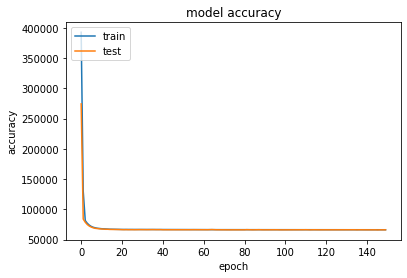

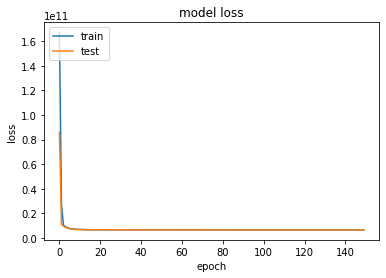

In [20]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This result is not very good and gives us a mean absolute error just above 20000 dollars. I beleive this model performs bad due to the fact that we have a quite small data-set becuase a neural network performs the best when having a big dataset. 

In [21]:
# Read in train data
try:
    df_train = pd.read_csv('df_listings_v06.csv', index_col=0)
except:
    !wget https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
    df_train = pd.read_csv('df_listings_v06.csv', index_col=0)

--2022-11-17 15:12:26--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451405 (441K) [text/plain]
Saving to: ‘house_prices_test.csv.2’

house_prices_test.c 100%[===================>] 440.83K  --.-KB/s    in 0.06s   

2022-11-17 15:12:26 (7.58 MB/s) - ‘house_prices_test.csv.2’ saved [451405/451405]



In [24]:
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

In [25]:
prediction = model.predict(X_test)

484/484 [==============================] - 0s 759us/step


In [33]:
submission = pd.DataFrame()
submission['Predicted Price'] = prediction.flatten()
submission['Actual'] = y_test
submission

,Price,Actual
0,486633.28125,550000.0
1,504380.25000,375000.0
2,524622.31250,450000.0
3,546821.75000,525000.0
4,439158.46875,599950.0
...,...,...
15463,465993.15625,390000.0
15464,360708.31250,290000.0
15465,455598.25000,275000.0
15466,433222.59375,425000.0
